# 1. Install Dependencies and Setup

In [1]:
#! pip install tensorflow opencv-python matplotlib tensorflow-macos tensorflow-metal

In [2]:
#!pip list

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

/var/folders/6j/nngh9d8x2qxc0v7rg_1t56_00000gn/T/ipykernel_13574/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 545 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

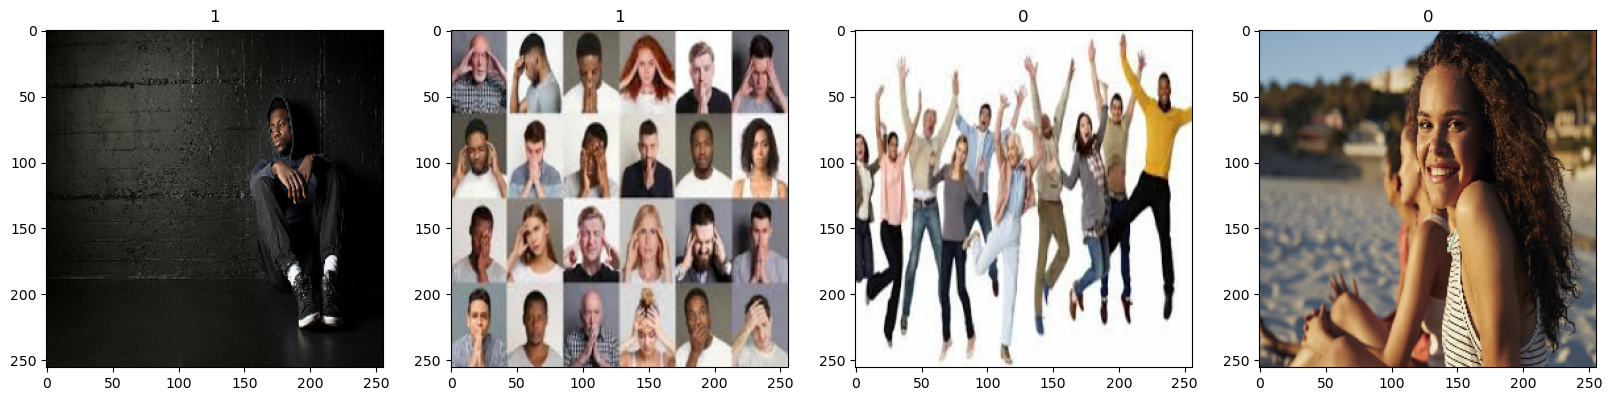

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x, y: (x/255, y))

In [16]:
scaled_iterator = data.as_numpy_iterator()

In [17]:
batch = scaled_iterator.next()

In [18]:
len(data)

18

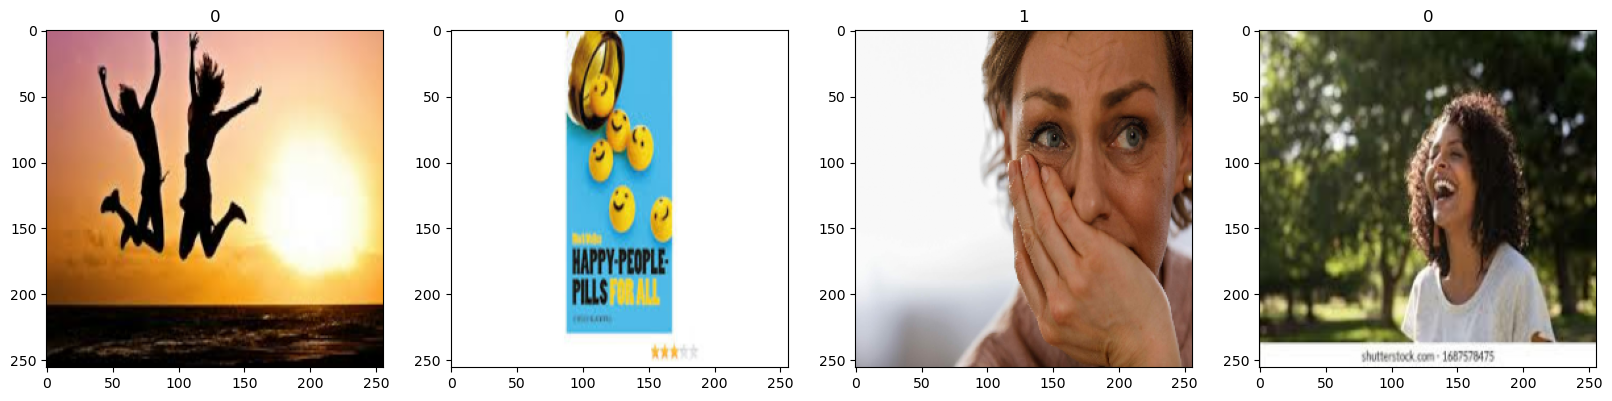

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# 5. Split Data

In [20]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [21]:
test_size, train_size, val_size

(2, 12, 4)

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [23]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input

In [25]:
model = Sequential()

In [26]:
model.add(Input(shape=(256, 256, 3)))
model.add(Conv2D(16, (3,3), 1, activation='relu', padding='valid'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu', padding='valid'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [29]:
logdir='logs'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - accuracy: 0.4475 - loss: 1.3223 - val_accuracy: 0.6016 - val_loss: 0.6749
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - accuracy: 0.6128 - loss: 0.6557 - val_accuracy: 0.5938 - val_loss: 0.6679
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - accuracy: 0.6619 - loss: 0.6160 - val_accuracy: 0.7266 - val_loss: 0.6263
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 301ms/step - accuracy: 0.6372 - loss: 0.6178 - val_accuracy: 0.7109 - val_loss: 0.5818
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - accuracy: 0.7034 - loss: 0.5651 - val_accuracy: 0.7891 - val_loss: 0.4964
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - accuracy: 0.7749 - loss: 0.5312 - val_accuracy: 0.8672 - val_loss: 0.3922
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 410ms/step - accuracy: 0.7956 - loss: 0.4495 - val_accuracy: 0.7969 - val_loss: 0.4711
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - accuracy: 0.8526 - loss: 0.3831 - val_accuracy: 0.

# 8. Plot Performance

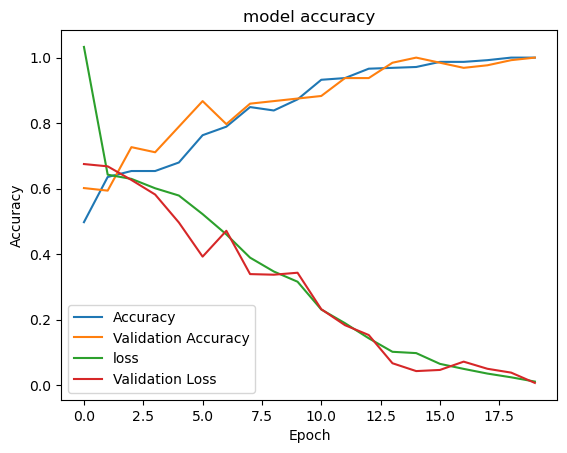

In [32]:

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])


plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

# 9. Evaluate

In [33]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [34]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
#f1 = (pre * re) / (pre + re)


In [35]:
print(' Presision %f' % pre.result(),'\n', 'Recall %f' % re.result(), '\n', 'Accuracy %f' % acc.result())

 Presision 0.000000 
 Recall 0.000000 
 Accuracy 0.000000


# 10. Test

In [36]:
import cv2

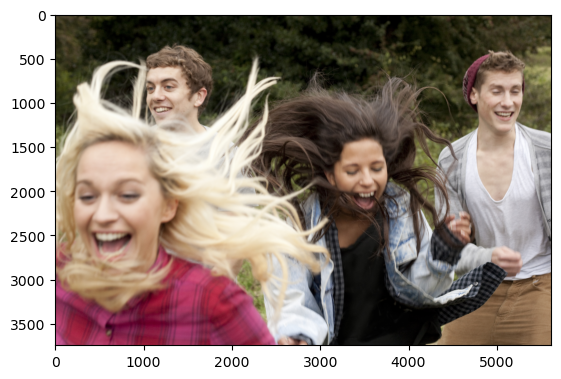

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted class is Happy [[0.06046582]]


In [37]:
img = cv2.imread('happy2.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()
resize = tf.image.resize(img, (256,256))
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat
if yhat > 0.5: 
    print(f'Predicted class is Sad', yhat)
else:
    print(f'Predicted class is Happy', yhat)

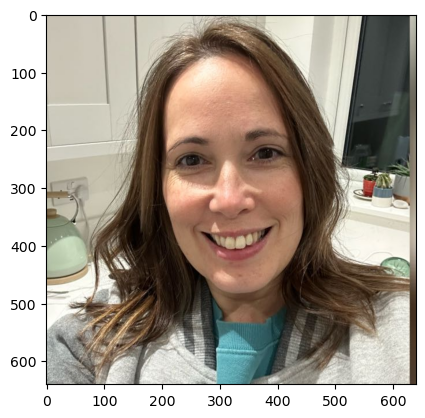

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted class is Happy [[0.01584198]]


In [38]:
img = cv2.imread('emily.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()
resize = tf.image.resize(img, (256,256))
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat
if yhat > 0.5: 
    print(f'Predicted class is Sad', yhat)
else:
    print(f'Predicted class is Happy', yhat)

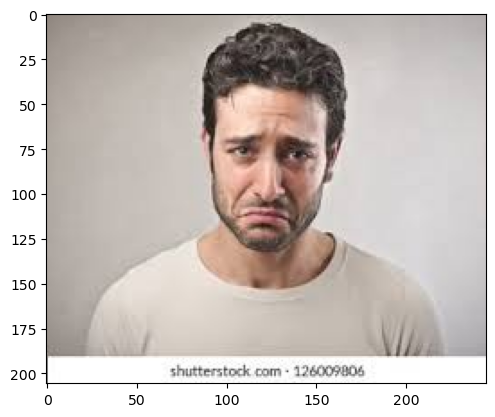

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted class is Sad [[0.95205384]]


In [39]:
img = cv2.imread('sad.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()
resize = tf.image.resize(img, (256,256))
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat
if yhat > 0.5: 
    print(f'Predicted class is Sad', yhat)
else:
    print(f'Predicted class is Happy', yhat)

# 11. Save the Model

In [40]:
from tensorflow.keras.models import load_model

In [41]:
model.save(os.path.join('models','imageclassifier.keras'))

In [43]:
new_model = load_model(os.path.join('models','imageclassifier.keras'))
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,089,877 (42.30 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,393,252 (28.20 MB)

In [44]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


array([[0.20509155]], dtype=float32)

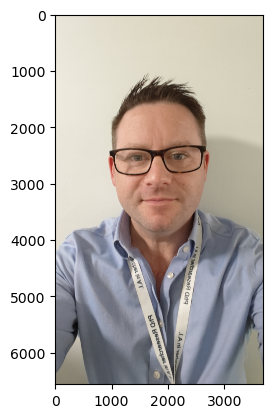

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predicted class is Happy [[0.20509155]]


In [45]:
img = cv2.imread('phil.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()
resize = tf.image.resize(img, (256,256))
yhat = new_model.predict(np.expand_dims(resize/255, 0))
yhat
if yhat > 0.5: 
    print(f'Predicted class is Sad', yhat)
else:
    print(f'Predicted class is Happy', yhat)

Copy to Raspberry pi

In [ ]:
#!scp -P 717 models/imageclassifier.keras phil@192.168.30.100:/tmp/imageclassifier.keras